# **TEAM CHALLENGUE: TOOLBOX**
## **Función: tipifica_variables**

Esta función permite clasificar automáticamente las variables de un DataFrame como:
- **Binaria**
- **Categórica**
- **Numérica Discreta**
- **Numérica Continua**

### **1. Definición de la función**

La función recibe:

- df: el DataFrame a analizar.

- umbral_categoria: número máximo de valores únicos para considerar una columna categórica.

- umbral_continua: porcentaje mínimo de valores únicos para considerar una columna como numérica continua.

```python
def tipifica_variables(df, umbral_categoria=10, umbral_continua=0.2):
```
### **2. Inicialización de resultados**

Se crea una lista vacía para guardar los resultados, y se calcula el número total de filas del DataFrame (n), necesario para calcular el porcentaje de cardinalidad.

```python
resultado = []
n = len(df)
```

### **3. Iteración por columnas del DataFrame**

Para cada columna:

- Se calcula la cardinalidad (número de valores únicos).

- Se calcula el porcentaje que representan esos valores únicos respecto al total de filas.

```python
for col in df.columns:
    cardinalidad = df[col].nunique()
    porcentaje_cardinalidad = round(cardinalidad / n, 2)
```

### **4. Clasificación de la variable**

Se aplica la lógica de clasificación:

- Si hay 2 valores únicos → Binaria
- Si hay menos de umbral_categoria → Categórica
- Si el porcentaje es alto → Numérica Continua
- Si no, se considera → Numérica Discreta

```python
if cardinalidad == 2:
        tipo = "Binaria"
    elif cardinalidad < umbral_categoria:
        tipo = "Categórica"
    elif porcentaje_cardinalidad >= umbral_continua:
        tipo = "Numerica Continua"
    else:
        tipo = "Numerica Discreta"
```

### **5. Guardar el resultado**

Se añade un diccionario con el nombre de la variable y su tipo sugerido a la lista resultado.

```python
resultado.append({
        "nombre_variable": col,
        "tipo_sugerido": tipo
    })
```

### **6. Devolver el resultado como DataFrame**

Finalmente, se transforma la lista de resultados en un DataFrame para facilitar su visualización y análisis posterior.

```python
return pd.DataFrame(resultado)
```

### **Ejemplo**

In [6]:
from toolbox_Sandra import tipifica_variables, get_features_cat_regression

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
# Ejecuta la función para clasificar las variables del Titanic
resultado_tipificacion = tipifica_variables(df, umbral_categoria=10, umbral_continua=0.2)

# Mostrar resultados
print("\nVariables clasificadas:")
resultado_tipificacion


Variables clasificadas:


,nombre_variable,tipo_sugerido
0,survived,Binaria
1,pclass,Categórica
2,sex,Binaria
3,age,Numerica Discreta
4,sibsp,Categórica
5,parch,Categórica
6,fare,Numerica Continua
7,embarked,Categórica
8,class,Categórica
9,who,Categórica


## Análisis de resultados

La función ha clasificado las variables del dataset del Titanic en cuatro tipos:

- Las variables como `sex` o `alive` aparecen como **Binarias**, lo cual es coherente ya que solo tienen dos posibles valores.
- Variables como `embarked`, `class`, `who`, `deck`, etc. son clasificadas como **Categóricas**, al tener pocos valores únicos.
- `fare` se clasifica como **Numérica Continua**, ya que tiene una alta variedad de valores únicos.
- Otras como `age`, `sibsp` o `parch` se consideran **Numéricas Discretas** por su baja cardinalidad relativa.

## **Función: get_features_cat_regression**

Esta función permite identificar qué variables categóricas del DataFrame están estadísticamente relacionadas con una variable numérica continua o discreta con alta cardinalidad.

Se basa en tests de significación estadística:
- **`ttest_ind`** para comparar medias cuando la variable categórica es binaria.
- **`f_oneway` (ANOVA)** para comparar medias entre más de dos grupos.

### **1. Validaciones de entrada**

Antes de hacer los cálculos, la función comprueba:

- Que el DataFrame sea válido
```python
if not isinstance(df, pd.DataFrame):
    print("'df' debe ser un DataFrame.")
    return None
```

- Que target_col está presente en el DataFrame.
```python
if target_col not in df.columns:
    print(f"La columna '{target_col}' no está en el DataFrame.")
    return None
```

- Que target_col es numérica.
```python
if not np.issubdtype(df[target_col].dtype, np.number):
    print(f"La columna '{target_col}' no es numérica.")
    return None
```

- Que el `pvalue` esté en el rango correcto (entre 0 y 1)
```python
if not (0 < pvalue < 1):
    print("'pvalue' debe estar entre 0 y 1.")
    return None
```

### **2. Comprobación de cardinalidad del target**

Se asegura que la variable objetivo tenga:

- Al menos 10 valores únicos

- Un 5% o más de variación respecto al total de filas
```python
cardinalidad = df[target_col].nunique()
porcentaje = cardinalidad / len(df)

if cardinalidad < 10 or porcentaje < 0.05:
    print(f"La variable '{target_col}' no tiene suficiente cardinalidad para considerarse continua.")
    print(f"Cardinalidad única: {cardinalidad} ({round(porcentaje * 100, 2)}%)")
    return None
```
Esto confirma que estamos ante una variable continua o discreta con alta cardinalidad.

### **3. Selección de variables categóricas**

Extrae las columnas categóricas del DataFrame. Si no hay ninguna, devuelve una lista vacía.
```python
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if not cat_cols:
    print("No hay variables categóricas en el DataFrame.")
    return []
```

### **4. Iteración por variables categóricas**

Para cada variable categórica:

- Se identifican los niveles únicos (niveles) excluyendo nulos.

- Se agrupan los valores de target_col según cada nivel.
```python
relacionadas = []

for col in cat_cols:
    niveles = df[col].dropna().unique()
    grupos = [df[df[col] == nivel][target_col].dropna() for nivel in niveles]
```

### **5. Verificación de tamaño de muestra**

Si alguno de los grupos tiene menos de 2 datos, se salta esa variable para evitar errores en el test estadístico.
```python
 if any(len(grupo) < 2 for grupo in grupos):
        continue
```

### **6. Aplicación del test estadístico**

Se escoge automáticamente el test adecuado:

- Si hay 2 niveles: se aplica ttest_ind (test T de Student).

- Si hay más de 2 niveles: se aplica f_oneway (ANOVA).

- Si por algún motivo hay menos de 2 niveles válidos, se ignora.
```python
 try:
        if len(niveles) == 2:
            stat, p = ttest_ind(*grupos)
        elif len(niveles) > 2:
            stat, p = f_oneway(*grupos)
        else:
            continue
```

### **7. Filtrado por significancia**

Si el valor p es inferior al umbral definido (pvalue), se considera que hay una relación estadísticamente significativa entre esa variable categórica y la variable target, y se añade a la lista de resultado.
```python
if p < pvalue:
            relacionadas.append(col)
```

### **8. Gestión de errores**

Si ocurre cualquier error durante el test, se muestra el mensaje y se continúa con la siguiente variable sin detener la función.
```python
except Exception as e:
        print(f"Error evaluando la columna '{col}': {e}")
        continue
```

### **9. Resultado final**

Devuelve una lista con las variables categóricas que están significativamente relacionadas con la variable numérica objetivo, según el valor de `p-value` elegido.

Cuanto más bajo sea el p-value, más estricta es la prueba.
```python
return relacionadas
```


In [3]:
# Revisar porcentaje de nulos
df.isnull().mean().sort_values(ascending=False)

deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
alive          0.000000
alone          0.000000
dtype: float64

In [4]:
# Seleccionamos columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Eliminamos nulos en target y en categóricas
df_clean = df.dropna(subset=['fare'] + list(cat_cols))

cat_card = df_clean[cat_cols].nunique().sort_values(ascending=False)
cat_card

deck           7
embarked       3
class          3
who            3
embark_town    3
sex            2
alive          2
dtype: int64

In [ ]:
relacionadas = get_features_cat_regression(df, target_col="fare")
print("Variables categóricas relacionadas con 'fare':", relacionadas)

Variables categóricas relacionadas con 'fare': ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']


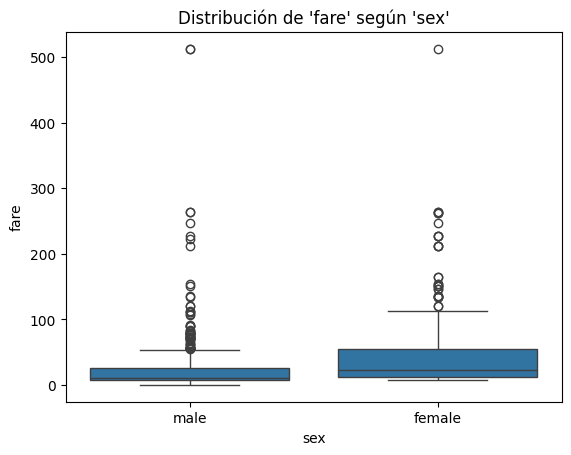

In [7]:
sns.boxplot(x="sex", y="fare", data=df)
plt.title("Distribución de 'fare' según 'sex'")
plt.show()